# Decision Tree

In [1]:
import numpy as np, matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
iris = datasets.load_iris()
print(iris.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In [3]:
print(iris.feature_names)
print(iris.target_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


In [4]:
X = iris.data[:, 2:]
y = iris.target

## Classification
using *scikit-learn*

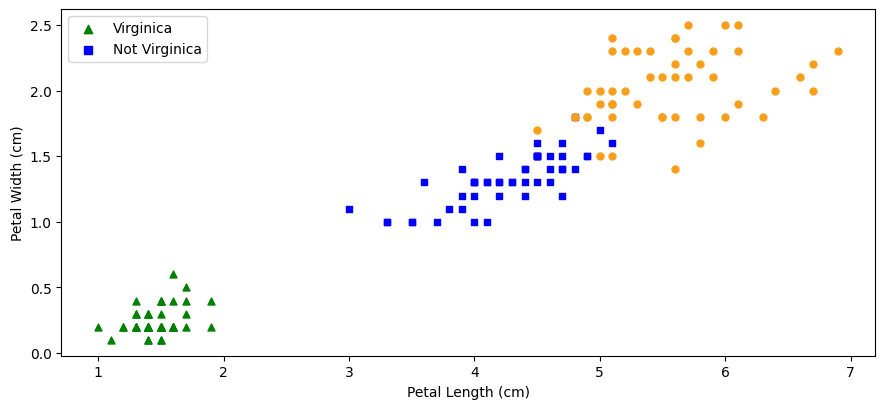

In [5]:
def plot_target(y):
    colors, markers = [], []
    for i in range(len(y)):
        if (y[i] == 0):
            colors.append('g')
            markers.append('^')
        elif (y[i] == 1):
            colors.append('b')
            markers.append('s')
        else:
            colors.append('#f79f1b')
            markers.append('o')
    return colors, markers
colors, markers = plot_target(y)

plt.figure(figsize=(10.5, 4.5))
for x_s, y_s, c, m in zip(X[:, 0], X[:, 1], colors, markers):
    a = plt.scatter(x_s, y_s, c=c, marker=m, s=25)
plt.legend([plt.scatter([], [], c='g', marker='^'), plt.scatter([], [], c='b', marker='s')], ['Virginica', 'Not Virginica'])
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.show()

In [6]:
from sklearn.tree import DecisionTreeClassifier

In [7]:
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)
print("accuracy:", sum(tree_clf.predict(X) == y) / len(y) * 100, "%")

accuracy: 96.0 %


In [8]:
from sklearn.tree import export_graphviz

In [9]:
export_graphviz(tree_clf, out_file='iris_tree.dot', feature_names=iris.feature_names[2:],
               class_names=iris.target_names, rounded=True, filled=True)

## Classification Implementation
using *cost function*, below

below are the options we can use to implement a Decision Tree

---
### cost function: $J(k, t_{K}) = \dfrac{m_{left}}{m}G_{left} + \dfrac{m_{right}}{m}G_{right}$
where $G = 1 - \sum p_{k}^{2}$ is called **Gini score**, and the objective is to *minimize* it

---
### information gain: $IG = E(parent) - \text{weighted average}(E(children))$
where $E = - \sum p_{k} . log_{2}(p_{k})$ is called **Entropy**, and the objective is to *maximize* IG

In [10]:
import statistics as st

class Node:
    
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None, depth=0):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.depth = depth
        
    def is_leaf_node(self):
        return self.value is not None
    
class DecisionTreeClf:
    
    def __init__(self, min_samples_split=2, max_depth=100, max_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.max_features = max_features
        self.root = None

    def fit(self, X, y):
        if self.min_samples_split < 1:
            raise Exception('invalid min_samples_split value')
        if self.max_depth < 1:
            raise Exception('invalid max_depth value')
        if self.max_features is not None and self.max_features < 1:
            raise Exception('invalid max_features value')
        self.max_features = X.shape[1] if self.max_features is None else min(X.shape[1], self.max_features)
        self.root = self._grow_tree(X, y)

    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
        
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # leaf node
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = st.mode(y)
            return Node(value=leaf_value, depth=depth)
        
        # internal node
        feature_idxs = np.random.choice(n_features, self.max_features, replace=False)
        best_feature_idx, best_threshold = self._best_split(X, y, feature_idxs)
        if (best_feature_idx is None or best_threshold is None):
            leaf_value = st.mode(y)
            return Node(value=leaf_value, depth=depth)
        
        # create children
        left_idxs, right_idxs = self._split(X[:, best_feature_idx], best_threshold)
        left = self._grow_tree(X[left_idxs], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs], y[right_idxs], depth + 1)
        return Node(best_feature_idx, best_threshold, left, right, depth=depth)
        
    
    def _best_split(self, X, y, feature_idxs):
        least_cost = 1
        split_feature_idx, split_threshold = None, None
        
        for feature_idx in feature_idxs:
            feature_column = X[:, feature_idx]
            thresholds = np.unique(feature_column)
            
            for threshold in thresholds:
                cost = self._calculate_split_cost(y, feature_column, threshold)
                
                if cost is None:
                    continue
                if cost < least_cost:
                    least_cost = cost
                    split_feature_idx = feature_idx
                    split_threshold = threshold
        return split_feature_idx, split_threshold
            
        
    def _calculate_split_cost(self, y, feature_column, threshold):
        # get splitted indexes
        n = len(y)
        left_idxs, right_idxs = self._split(feature_column, threshold)
        
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return None
        
        n_left, n_right = len(left_idxs), len(right_idxs)
        g_left, g_right = self._gini(y[left_idxs]), self._gini(y[right_idxs])
        cost = (n_left / n) * g_left + (n_right / n) * g_right
        return cost
        
        
    def _gini(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        gini = 1 - sum([p ** 2 for p in ps])
        return gini
        
        
    def _split(self, feature_column, threshold):
        left_idxs = np.argwhere(feature_column < threshold).flatten()
        right_idxs = np.argwhere(feature_column >= threshold).flatten()
        return left_idxs, right_idxs
    
    
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature] >= node.threshold:
            return self._traverse_tree(x, node.right)
        return self._traverse_tree(x, node.left)
    
    def _print_tree(self, node):
        self._space(4 * node.depth)
        print('*')
        self._space(4 * node.depth)
        print('feature:', node.feature)
        self._space(4 * node.depth)
        print('threshold:', node.threshold)
        if (node.is_leaf_node):
            self._space(4 * node.depth)
            print('value:', node.value)   
        self._space(4 * node.depth)
        print('*')
        
        if node.is_leaf_node():
            return
        self._print_tree(node.left)
        self._print_tree(node.right)
        return
    
    
    def _space(self, n):
        for _ in range(n):
            print(' ', end='')

In [11]:
tree_clf = DecisionTreeClf(max_depth=3)
tree_clf.fit(X, y)
y_pred = tree_clf.predict(X)
print("accuracy:", sum(y_pred == y) / len(y) * 100, "%")
tree_clf._print_tree(tree_clf.root)

accuracy: 97.33333333333334 %
*
feature: 1
threshold: 1.0
value: None
*
    *
    feature: None
    threshold: None
    value: 0
    *
    *
    feature: 1
    threshold: 1.8
    value: None
    *
        *
        feature: 0
        threshold: 5.0
        value: None
        *
            *
            feature: None
            threshold: None
            value: 1
            *
            *
            feature: None
            threshold: None
            value: 2
            *
        *
        feature: 0
        threshold: 4.9
        value: None
        *
            *
            feature: None
            threshold: None
            value: 2
            *
            *
            feature: None
            threshold: None
            value: 2
            *


## Regression
using *scikit-learn*

In [12]:
np.random.seed(42)
X = np.linspace(-1, 3, 100).reshape(-1, 1)
y = X.ravel() ** 2 + 0.6 * np.random.randn(100)

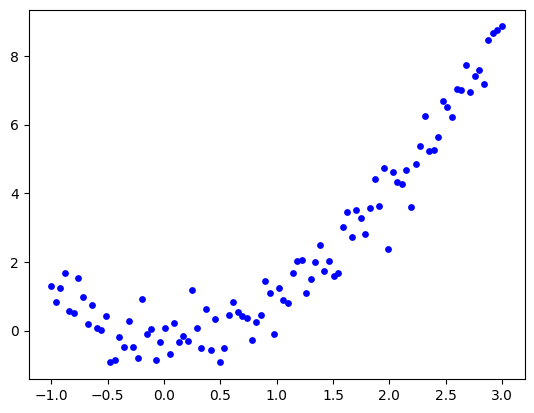

In [13]:
plt.scatter(X, y, c='b', s=15)
plt.show()

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [15]:
tree_reg = DecisionTreeRegressor(max_depth=3)
tree_reg.fit(X, y)
y_pred = tree_reg.predict(X)
print("rmse:", np.sqrt(mean_squared_error(y, y_pred)))

rmse: 0.5336335054792878


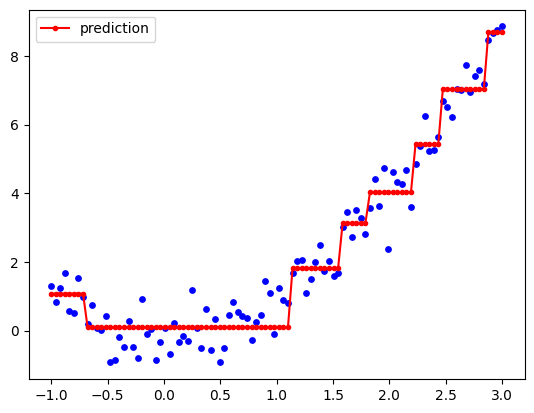

In [16]:
plt.scatter(X, y, c='b', s=15)
plt.plot(X, y_pred, c='r', marker='o', ms=3, label='prediction')
plt.legend()
plt.show()

## Regression Implementation

### cost function: $J(k, t_{K}) = \dfrac{m_{left}}{m}MSE_{left} + \dfrac{m_{right}}{m}MSE_{right}$
where $MSE = \sum (\hat{y}_{node} - y^{(i)})^{2}$ and $\hat{y}_{node} = \dfrac{1}{m_{node}} \sum y^{(i)}$

In [17]:
import statistics as st

class Node:
    
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None, depth=0):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.depth = depth
        
    def is_leaf_node(self):
        return self.value is not None
    
class DecisionTreeReg:
    
    def __init__(self, min_samples_split=2, max_depth=100, max_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.max_features = max_features
        self.root = None

    def fit(self, X, y):
        if self.min_samples_split < 1:
            raise Exception('invalid min_samples_split value')
        if self.max_depth < 1:
            raise Exception('invalid max_depth value')
        if self.max_features is not None and self.max_features < 1:
            raise Exception('invalid max_features value')
        self.max_features = X.shape[1] if self.max_features is None else min(X.shape[1], self.max_features)
        self.root = self._grow_tree(X, y)

    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
        
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # leaf node
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = st.mean(y)
            return Node(value=leaf_value, depth=depth)
        
        # internal node
        feature_idxs = np.random.choice(n_features, self.max_features, replace=False)
        best_feature_idx, best_threshold = self._best_split(X, y, feature_idxs)
        if (best_feature_idx is None or best_threshold is None):
            leaf_value = st.mean(y)
            return Node(value=leaf_value, depth=depth)
        
        # create children
        left_idxs, right_idxs = self._split(X[:, best_feature_idx], best_threshold)
        left = self._grow_tree(X[left_idxs], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs], y[right_idxs], depth + 1)
        return Node(best_feature_idx, best_threshold, left, right, depth=depth)
        
    
    def _best_split(self, X, y, feature_idxs):
        least_cost = float('inf')
        split_feature_idx, split_threshold = None, None
        
        for feature_idx in feature_idxs:
            feature_column = X[:, feature_idx]
            thresholds = np.unique(feature_column)
            
            for threshold in thresholds:
                cost = self._calculate_split_cost(y, feature_column, threshold)
                
                if cost is None:
                    continue
                if cost < least_cost:
                    least_cost = cost
                    split_feature_idx = feature_idx
                    split_threshold = threshold
        return split_feature_idx, split_threshold
            
        
    def _calculate_split_cost(self, y, feature_column, threshold):
        # get splitted indexes
        n = len(y)
        left_idxs, right_idxs = self._split(feature_column, threshold)
        
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return None
        
        n_left, n_right = len(left_idxs), len(right_idxs)
        mse_left, mse_right = self._mse(y[left_idxs]), self._mse(y[right_idxs])
        cost = (n_left / n) * mse_left + (n_right / n) * mse_right
        return cost
        
        
    def _mse(self, y):
        y_pred = sum(y) / len(y)
        mse = sum([(y_pred - y_i) ** 2 for y_i in y])
        return mse
        
        
    def _split(self, feature_column, threshold):
        left_idxs = np.argwhere(feature_column < threshold).flatten()
        right_idxs = np.argwhere(feature_column >= threshold).flatten()
        return left_idxs, right_idxs
    
    
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature] >= node.threshold:
            return self._traverse_tree(x, node.right)
        return self._traverse_tree(x, node.left)
    
    def _print_tree(self, node):
        self._space(4 * node.depth)
        print('*')
        self._space(4 * node.depth)
        print('feature:', node.feature)
        self._space(4 * node.depth)
        print('threshold:', node.threshold)
        if (node.is_leaf_node):
            self._space(4 * node.depth)
            print('value:', node.value)   
        self._space(4 * node.depth)
        print('*')
        
        if node.is_leaf_node():
            return
        self._print_tree(node.left)
        self._print_tree(node.right)
        return
    
    
    def _space(self, n):
        for _ in range(n):
            print(' ', end='')

In [18]:
tree_reg = DecisionTreeReg(max_depth=3)
tree_reg.fit(X, y)
y_pred = tree_reg.predict(X)
print("rmse:", np.sqrt(mean_squared_error(y, y_pred)))
tree_reg._print_tree(tree_reg.root)

rmse: 0.5627466939970829
*
feature: 0
threshold: 1.585858585858586
value: None
*
    *
    feature: 0
    threshold: 0.8585858585858588
    value: None
    *
        *
        feature: 0
        threshold: -0.4747474747474747
        value: None
        *
            *
            feature: None
            threshold: None
            value: 0.7718570365310451
            *
            *
            feature: None
            threshold: None
            value: -0.08148624704652878
            *
        *
        feature: 0
        threshold: 1.1414141414141414
        value: None
        *
            *
            feature: None
            threshold: None
            value: 0.8327461366947203
            *
            *
            feature: None
            threshold: None
            value: 1.808320324145449
            *
    *
    feature: 0
    threshold: 2.3131313131313136
    value: None
    *
        *
        feature: 0
        threshold: 2.0303030303030307
        value: None
  

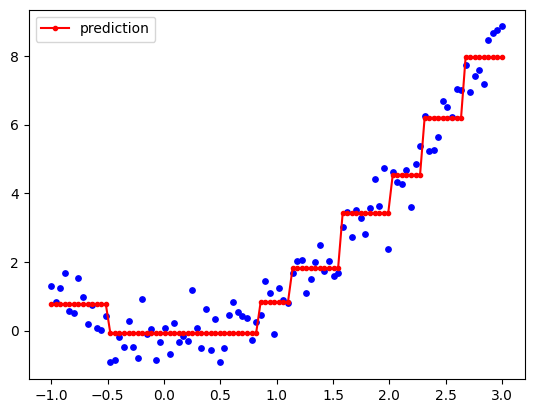

In [19]:
plt.scatter(X, y, c='b', s=15)
plt.plot(X, y_pred, c='r', marker='o', ms=3, label='prediction')
plt.legend()
plt.show()